In [18]:
import matplotlib.pyplot as plt
import numpy as np 
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot

import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 10

### Reading fMRI data

In [45]:
fmri_img = nib.load('/Users/rodrigo/Medium/GLM_Orcutt/Stroop.nii')
fmri_data = fmri_img.get_fdata()
#print(fmri_img.header)

In [46]:
#(X,Y,Z (coordinates), T (time))
fmri_data.shape

(45, 54, 45, 180)

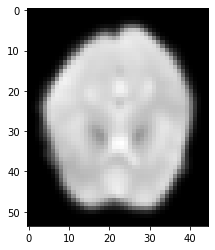

In [47]:
# Image of the Brain
plt.imshow(fmri_data[:,:,18,0].T, cmap='Greys_r')
plt.show()

### Reading task data

In [23]:
cong = np.loadtxt('/Users/rodrigo/Medium/GLM_Orcutt/congruent.txt')
incong = np.loadtxt('/Users/rodrigo/Medium/GLM_Orcutt/incongruent.txt')

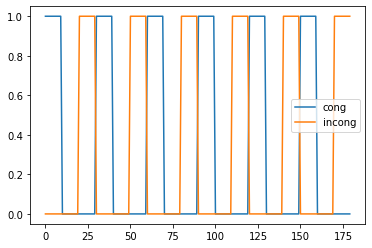

In [24]:
plt.plot(cong, label='cong')
plt.plot(incong, label='incong')
plt.legend()

## Creating the HRF

In [25]:
def glover(HZ):
    '''
        HRF
    '''
    a1 = 6
    a2 = 12
    b1 = 0.9
    b2 = 0.9
    d1 = 5.4
    d2 = 10.8
    c = 0.35
    x = np.arange(0, 30, .5 / HZ)  # HZ is the Sampling Rate (Heartz)
    glover1 = ((x / d1) ** a1) * np.exp((-x + d1) / b1)
    glover2 = ((x / d2) ** a2) * np.exp((-x + d2) / b2)
    G = glover1 - c * glover2
    return G

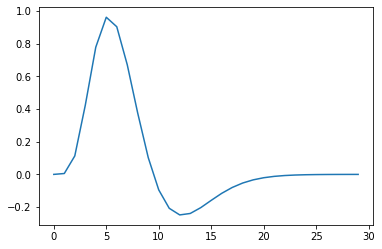

In [26]:
HRF = glover(.5)
plt.plot(HRF)
plt.show()

### Convolve task information with HRF

In [27]:
conv_cong = np.convolve(cong.ravel(), HRF.ravel(), mode='same')
conv_incong = np.convolve(incong.ravel(), HRF.ravel(), mode='same')

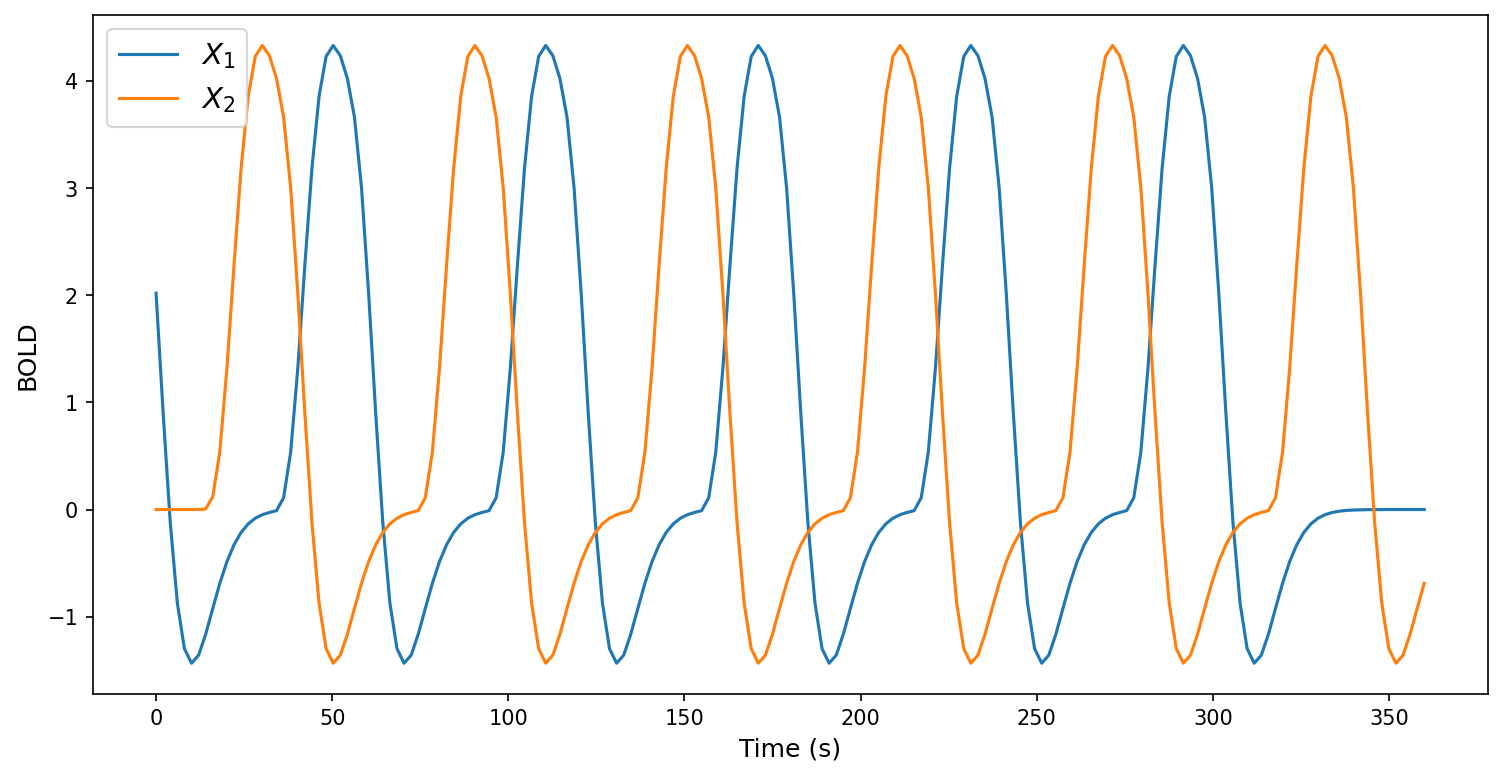

In [28]:
plt.figure(dpi=150, figsize=(12,6))
plt.plot(np.linspace(0,360,180),conv_cong, label=r'$X_1$')
plt.plot(np.linspace(0,360,180),conv_incong, label=r'$X_2$')
plt.xlabel('Time (s)')
plt.ylabel('BOLD')
plt.legend(prop={'size' : 14})
plt.show()

### Fitting a GLM 

In [29]:
import statsmodels.api as sm

y = fmri_data[20,30,30]#[22,27,20]
x = np.array([conv_incong, conv_cong]).T

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y,x).fit()

#view model summary
print(model.summary())
params = model.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     11.42
Date:                Wed, 22 Nov 2023   Prob (F-statistic):           2.16e-05
Time:                        13:23:39   Log-Likelihood:                -847.90
No. Observations:                 180   AIC:                             1702.
Df Residuals:                     177   BIC:                             1711.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.074e+04      2.660   4037.120      0.0

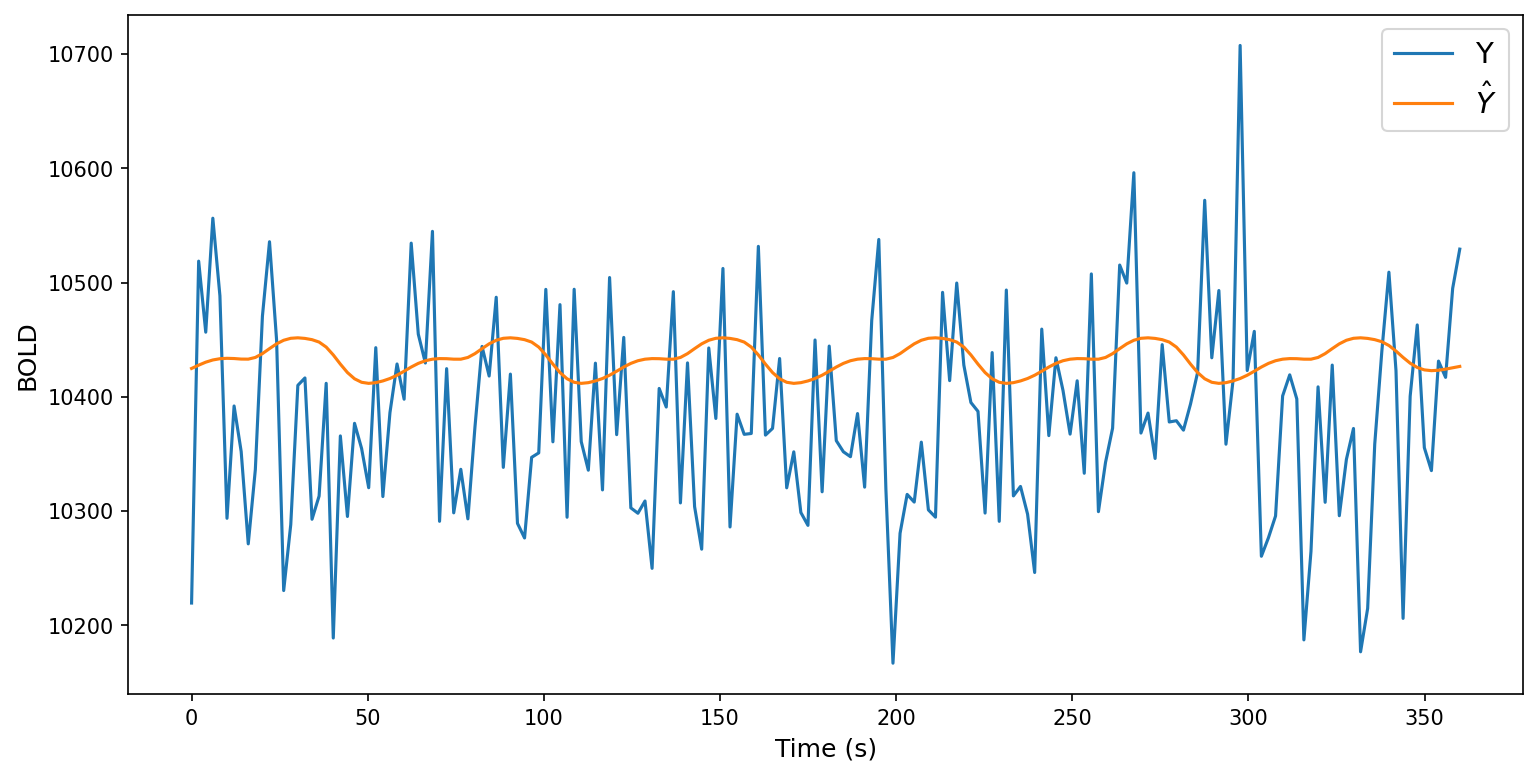

In [30]:
Y_hat = -2.5670 *conv_cong +  4.9660 *conv_incong + 1.043e+04 
plt.figure(dpi=150, figsize=(12,6))
plt.plot(np.linspace(0,360,180),fmri_data[22,27,20], label='Y')
plt.plot(np.linspace(0,360,180),Y_hat, label='$\hat{Y}$')
plt.xlabel('Time (s)')
plt.ylabel('BOLD')
plt.legend(prop={'size' : 14})
plt.show()

### Checking residuals autocorrelation

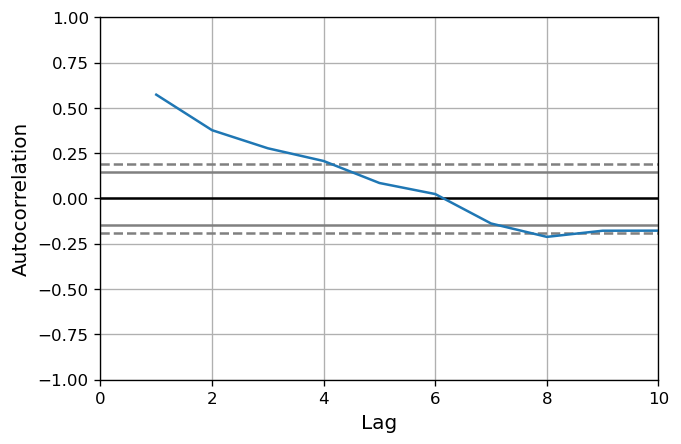

In [31]:
import pandas as pd

# Residuals
Resid = y - Y_hat

plt.figure(dpi=120)
pd.plotting.autocorrelation_plot(Resid)
plt.xlim(0,10)
plt.show()

### Cochrane-Orcutt procedure for AR(1)

In [32]:
yt = y[2:180]
yt1 = y[1:179]
rho= np.corrcoef(yt,yt1)[0,1]
Y2= yt - rho*yt1
X2 = x[2:180,1:] - rho*x[1:179,1:]

### Fitting the GLM again

In [33]:
import statsmodels.api as sm

#y = fmri_data[20,30,30]#[22,27,20]
#x = np.array([conv_incong, conv_cong]).T

#add constant to predictor variables
X2 = sm.add_constant(X2)

#fit linear regression model
model = sm.OLS(Y2,X2).fit()

#view model summary
print(model.summary())
params = model.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     4.920
Date:                Wed, 22 Nov 2023   Prob (F-statistic):            0.00834
Time:                        13:23:40   Log-Likelihood:                -829.49
No. Observations:                 178   AIC:                             1665.
Df Residuals:                     175   BIC:                             1675.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6531.5118      2.496   2616.366      0.0

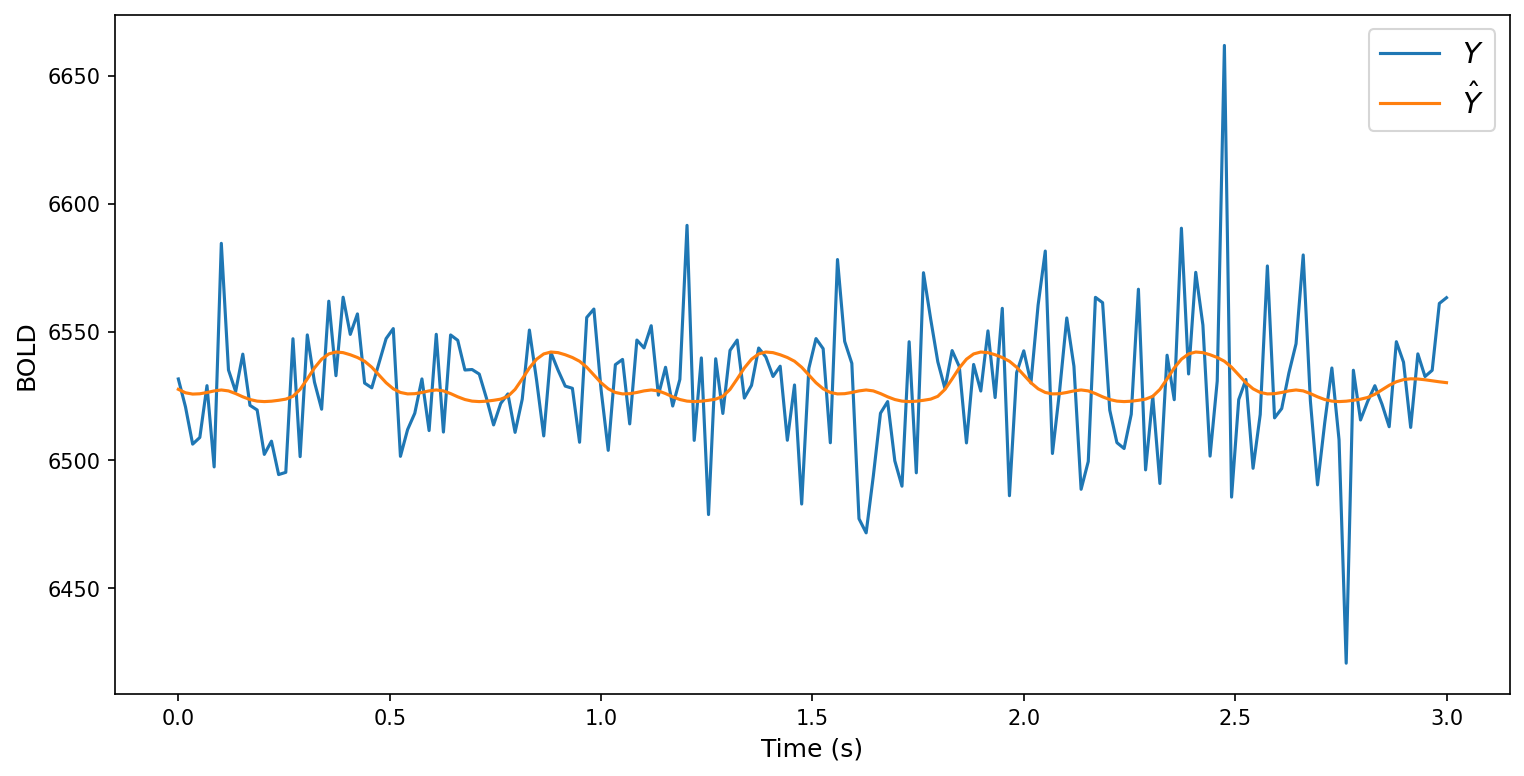

In [34]:
Y_hat = -2.3887 *X2[:,1] +  3.8428 *X2[:,2] + 6529.4570
plt.figure(dpi=150, figsize=(12,6))
plt.plot(np.linspace(0,3,178),Y2, label=r'$Y$')
plt.plot(np.linspace(0,3,178),Y_hat, label=r'$\hat{Y}$')
plt.legend(prop={'size' : 14})
plt.xlabel('Time (s)')
plt.ylabel('BOLD')
plt.show()

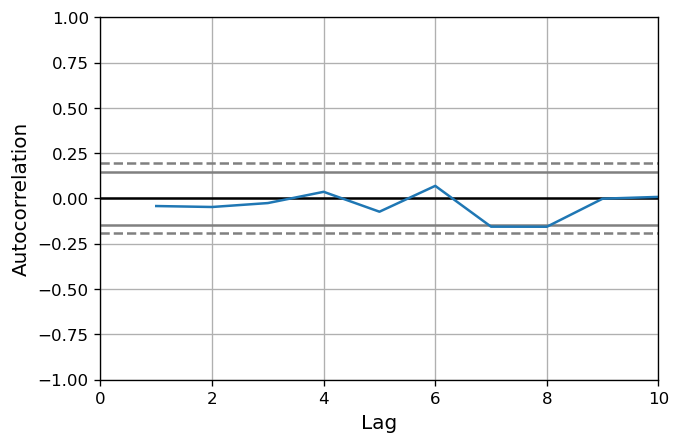

In [35]:
import pandas as pd

# Residuals
Resid = Y2 - Y_hat

plt.figure(dpi=120)
pd.plotting.autocorrelation_plot(Resid)
plt.xlim(0,10)
plt.show()